# Lang Graph
---

A system that consists of a question, a LLM + RAG to a knowledge base, and gives out an answer is a chatbot although not an Agent.

-> Workflows are systems where LLMs and tools are orchestrated by predefined code paths.

-> Agents are systems where LLMs dynamically direct their own processes and tools usages, and have control on how they operate, they dont need to be told exactly what to do.

![Captura de Tela 2025-09-20 às 23.48.51.png](<attachment:Captura de Tela 2025-09-20 às 23.48.51.png>)


Considering the structure of a network, each dot (object) is a node and the nodes connection is called Edges. The networking is then formed by dots and Edges.

A networking structure also has State (could be understood as object or parameter) that is passed along the network. It goes through the nodes and is modified in the Edges (in between Edges).
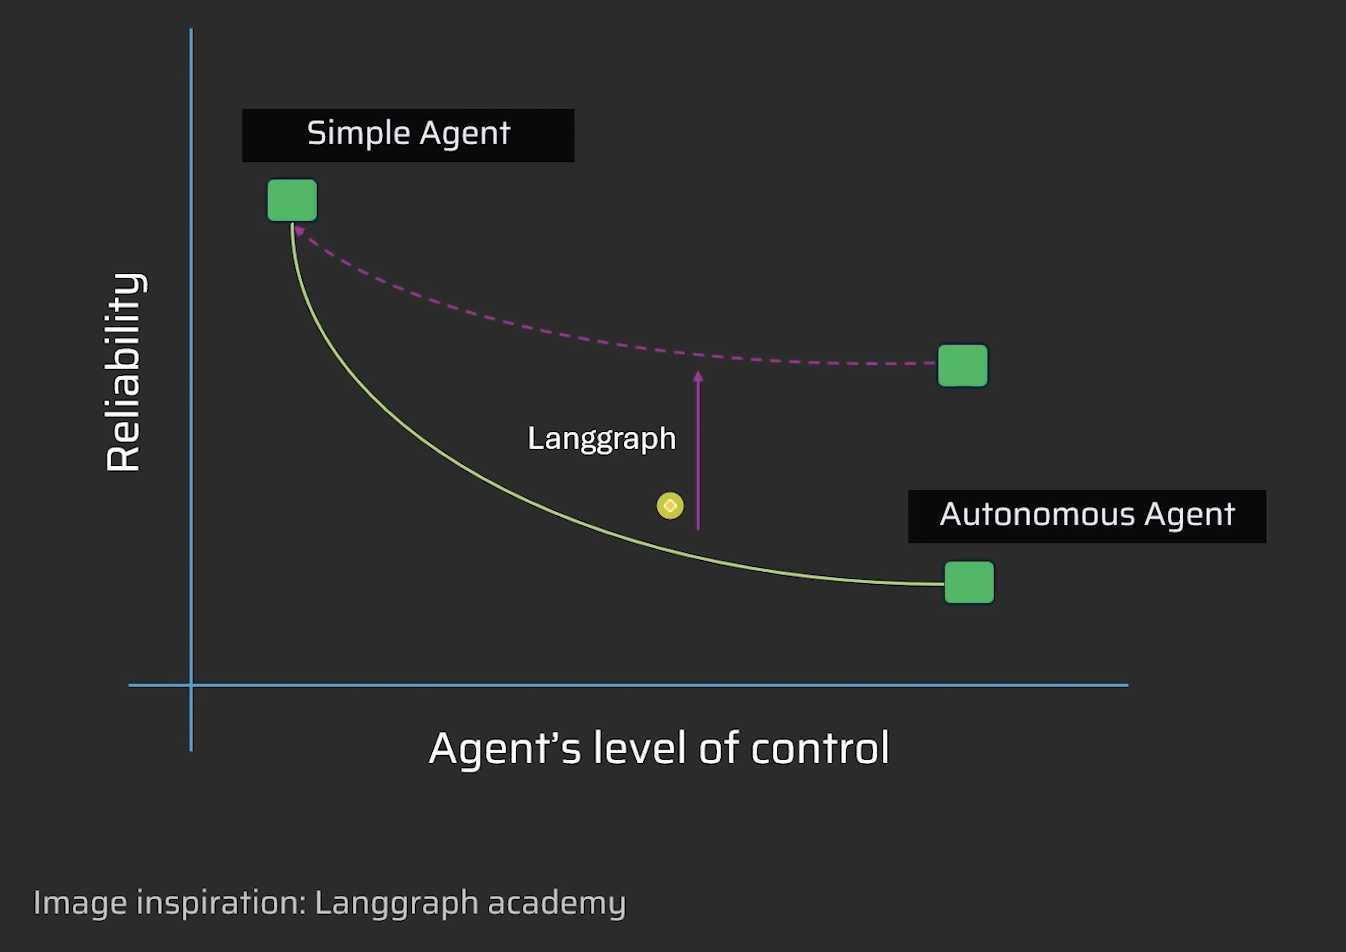

In [1]:
pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [langgraph]/6 [langgraph]
Note: you may need to restart the kernel to use updated packages.


In [11]:
from typing import TypedDict

class PortfolioState(TypedDict):
    amount_usd : float
    total_usd: float
    total_brl: float

# Creating the nodes
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_brl(state: PortfolioState) -> PortfolioState:
    state['total_brl'] = state['total_usd'] * 6
    return state

# Calling the graph

from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node('calc_total_node', calc_total)
builder.add_node('convert_to_brl_node', convert_to_brl)

builder.add_edge(START, 'calc_total_node')
builder.add_edge('calc_total_node', 'convert_to_brl_node')
builder.add_edge('convert_to_brl_node', END)

graph = builder.compile()

from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png(max_retries=5)
    )
)

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 500.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [12]:
graph.invoke({'amount_usd':1000})

{'amount_usd': 1000, 'total_usd': 1080.0, 'total_brl': 6480.0}

How to add conditions to the network? 

In [ ]:
from typing import TypedDict, Literal, Annotated

class PortfolioState(TypedDict):
    amount_usd : float
    total_usd: float
    target_currency: Literal["BRL","EUR"]
    total: float # <- changed to a more generic

# Creating the nodes
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_brl(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 6
    return state

def convert_to_eur(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 0.9
    return state

def choose_conversion(state: PortfolioState) -> str:
    return state['target_currency']

# Calling the graph

from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node('calc_total_node', calc_total)
builder.add_node('convert_to_brl_node', convert_to_brl)
builder.add_node('convert_to_eur_node', convert_to_eur)


builder.add_edge(START, 'calc_total_node')

builder.add_conditional_edges('calc_total_node',
                              choose_conversion,
                              {
                                  "BRL": "convert_to_brl_node",
                                  "EUR":"convert_to_eur_node"
                              }
                              )

# builder.add_edge('calc_total_node', 'convert_to_brl_node')
# builder.add_edge('convert_to_brl_node', END)
builder.add_edge(['convert_to_brl_node','convert_to_eur_node'], END)


graph = builder.compile()

from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png(max_retries=5)
    )
)

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

How does all of this connects when using a chatbot?

In [17]:
from dotenv import load_dotenv
import os 
load_dotenv()

# from langchain.chat_models import 
from openai import OpenAI, APIConnectionError

# ---- OpenAI (standard) config ----
OPENAI_API_KEY  = os.getenv("FELIPE_OPENAI_API_KEY")        # required
OPENAI_MODEL    = os.getenv("FELIPE_OPENAI_MODEL", "gpt-5")  # e.g., "gpt-5" or "gpt-5-mini"


client = OpenAI(api_key=OPENAI_API_KEY)
question = 'Tell me about the weather in Lisbon tonight'
resp = client.responses.create(
    model=OPENAI_MODEL,
    input=[
        # {"role": "system",
        # "content": f"""
        #     {prompt_sys}
        # """},
        {"role": "user", 
        "content": f"""Input: \n {question}
        """},
    ]
)

print(resp.output_text)

I can’t access live weather data. If you share the date (and whether you prefer °C or °F), I can tailor an outlook. Generally, Lisbon nights are:

- Winter: 7–12°C (45–54°F), frequent showers, breezy.
- Spring: 10–16°C (50–61°F), mild, occasional light rain.
- Summer: 17–22°C (63–72°F), usually clear, NW sea breeze (nortada).
- Autumn: 12–18°C (54–64°F), mild, periodic showers.

For a precise forecast, check IPMA (Portugal’s meteorological service), Meteo.pt, or a weather app for “Lisboa” tonight.


In [35]:
class State(TypedDict):
    messages: list

def chatbot(state: State) -> State:
    comp = client.responses.create(
        model=OPENAI_MODEL,
        input=state["messages"]  # pass messages directly
    )
    msg = comp.output_text
    return {
        "messages": [{"role": "assistant", "content": msg}]
    }

builder = StateGraph(State)
builder.add_node('chatbot_node', chatbot)

builder.add_edge(START, 'chatbot_node')
builder.add_edge('chatbot_node', END)

graph = builder.compile()

message = {
    "role": "user",
    "content": [
        {"type": "input_text", "text": str(question)}
    ]
}
resp = graph.invoke({'messages':[message]})
resp['messages']

[{'role': 'assistant',
  'content': 'I don’t have live weather data. For an accurate forecast for Lisbon tonight, check:\n- IPMA (Portugal’s official weather service): ipma.pt\n- Google Weather or Apple Weather\n- Weather.com or Windy\n\nIf you paste the forecast (or share a screenshot), I can summarize it (temps, rain chance, wind) and suggest what to wear and the best time to head out. If you’d like a typical late‑September evening overview instead, I can provide that too.'}]

How do we preserve the memory of the chat for the chat?

In [ ]:
from typing import TypedDict, Literal, Annotated, List, Dict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages # State Reducer -> allows to preserve user messages (State)

class State(TypedDict):
    messages: Annotated[list, add_messages] # <- This part allows to preserve user messages

def _to_openai_chat(msgs: List[BaseMessage]) -> List[Dict[str, str]]:
    out = []
    for m in msgs:
        if isinstance(m, HumanMessage):
            out.append({"role": "user", "content": str(m.content)})
        elif isinstance(m, AIMessage):
            out.append({"role": "assistant", "content": str(m.content)})
        elif isinstance(m, SystemMessage):
            out.append({"role": "system", "content": str(m.content)})
        else:
            out.append({"role": getattr(m, "role", "user"), "content": str(m.content)})
    return out

def chatbot(state: State) -> State:
    msgs = _to_openai_chat(state["messages"]) 
    comp = client.chat.completions.create(
        model=OPENAI_MODEL,
        messages=msgs  # pass messages directly
    )
    msg = comp.choices[0].message.content
    return {
        "messages": [{"role": "assistant", "content": msg}]
    }

builder = StateGraph(State)
builder.add_node('chatbot_node', chatbot)

builder.add_edge(START, 'chatbot_node')
builder.add_edge('chatbot_node', END)

graph = builder.compile()

message = {
    "role": "user",
    "content": question
}
resp = graph.invoke({'messages':[message]})

resp

In [60]:
resp

{'messages': [HumanMessage(content='Tell me about the weather in Lisbon tonight', additional_kwargs={}, response_metadata={}, id='b26a760a-43a8-432e-b423-cb559f010d26'),
  AIMessage(content='I don’t have live weather access. If you’d like, I can look up the latest forecast online—just say yes.\n\nTypical for Lisbon on a September night: mild and mostly dry, lows around 16–20°C (60–68°F), light NW breeze, usually clear to partly cloudy with a low chance of rain. A light jacket or sweater is usually enough.\n\nTell me the time window or your plans, and I can tailor advice.', additional_kwargs={}, response_metadata={}, id='cb568cb5-1c7b-4bd9-9cab-8a11c86578f6')]}

In [61]:

# TESTING MEMORY IN LOOP

state = None
while True:
    in_message = input("You: ")
    if in_message.lower() in {"quit","exit"}:
        break
    if state is None:
        state: State = {
            "messages": [{"role": "user", "content": in_message}]
        }
    else:
        state["messages"].append({"role": "user", "content": in_message})

    state = graph.invoke(state)
    print("Bot:", state["messages"][-1].content)

Bot: Usually “Einstein” refers to Albert Einstein (1879–1955), the German‑born theoretical physicist famous for reshaping our understanding of space, time, and energy.

Key points:
- Developed special relativity (1905) and general relativity (1915); introduced E=mc² (mass–energy equivalence).
- Won the 1921 Nobel Prize in Physics for explaining the photoelectric effect, a cornerstone of quantum theory.
- Other major contributions: Brownian motion (evidence for atoms), Bose–Einstein statistics/condensate, stimulated emission (basis of lasers), and the EPR paradox.
- Career and life: studied/worked in Switzerland; “annus mirabilis” papers in 1905; professor in Zurich, Prague, Berlin; emigrated to the U.S. in 1933; Institute for Advanced Study, Princeton; died in 1955.
- Public figure: advocated for civil rights and world peace; warned about Nazi Germany and co‑signed the 1939 letter to FDR that helped spur the Manhattan Project.

If you meant a different “Einstein” (e.g., a company/produ

KeyboardInterrupt: 

How do we introduce TOOLS?

In [99]:
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

@tool
def get_stock_price(symbol: str) -> float:
    """Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    """
    return {
        'MSFT': 200,
        'AAPL': 123,
        'BRL': 500
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)
llm_with_tools = llm.bind_tools(tools)  # enables tool calling on the model

def chatbot(state: State) -> State:
    # Pass LangChain Messages; model may return an AIMessage with .tool_calls
    ai_msg = llm_with_tools.invoke(state["messages"])
    # Returning in this format lets add_messages append to history
    return {"messages": [ai_msg]}



builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))  # executes tool calls

# builder.add_node("tools", ToolNode(TOOLS)) 

builder.add_edge(START, "chatbot") 
builder.add_conditional_edges("chatbot", tools_condition)#, {"tools": "tools", "__end__": END})
builder.add_edge("tools", "chatbot")

graph = builder.compile()

In [100]:
display('https://mermaid.live/img/pako:eNpVjcFugkAQhl9lM6c2QaMgintoUqH1YtIePBU8TGBgibJLliXWAu_eBdO0ndNMvu__p4NUZQQc8ou6pgK1YccokczOcxwKXTamwubEZrOnfk-GVUrSrWe7h71ijVB1Xcri8e7vRomF3WHUiBlRyvNwR-GUf5PUsyg-YG1UffpLjlfVs5e4fBe2_j8RmmzqNc6R5zhLUbMQ9aSAA4UuM-BGt-RARbrC8YRupAkYQRUlwO2aoT4nkMjBZmqUH0pVPzGt2kKA7b409mrrDA1FJRYafxWSGelQtdIAX26mCuAdfAJ3t-v51o7n-6vtJhjhDbjnzhdrdxV4q8AN1kt_cOBrermYBxt_-AbWonK2')

'https://mermaid.live/img/pako:eNpVjcFugkAQhl9lM6c2QaMgintoUqH1YtIePBU8TGBgibJLliXWAu_eBdO0ndNMvu__p4NUZQQc8ou6pgK1YccokczOcxwKXTamwubEZrOnfk-GVUrSrWe7h71ijVB1Xcri8e7vRomF3WHUiBlRyvNwR-GUf5PUsyg-YG1UffpLjlfVs5e4fBe2_j8RmmzqNc6R5zhLUbMQ9aSAA4UuM-BGt-RARbrC8YRupAkYQRUlwO2aoT4nkMjBZmqUH0pVPzGt2kKA7b409mrrDA1FJRYafxWSGelQtdIAX26mCuAdfAJ3t-v51o7n-6vtJhjhDbjnzhdrdxV4q8AN1kt_cOBrermYBxt_-AbWonK2'

In [98]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

The current price of AAPL stock is $123.


In [101]:
state = graph.invoke({"messages": [{"role": "user", "content": "Using the current price tell me the total price of 10 AAPL stocks and add it to previous found price"}]})
print(state["messages"][-1].content)

Could you please provide me with the previous price you found so that I can calculate the total for you?


It doesnt remember the previous state. 

How to implement memory for the chat?


In [13]:
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os 
load_dotenv()

# ---- OpenAI (standard) config ----
OPENAI_API_KEY  = os.getenv("FELIPE_OPENAI_API_KEY")        # required
OPENAI_MODEL    = os.getenv("FELIPE_OPENAI_MODEL", "gpt-5")  # e.g., "gpt-5" or "gpt-5-mini"


memory = MemorySaver()



class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

@tool
def get_stock_price(symbol: str) -> float:
    """Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    """
    return {
        'MSFT': 200,
        'AAPL': 123,
        'BRL': 500
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)
llm_with_tools = llm.bind_tools(tools)  # enables tool calling on the model

def chatbot(state: State) -> State:
    # Pass LangChain Messages; model may return an AIMessage with .tool_calls
    ai_msg = llm_with_tools.invoke(state["messages"])
    # Returning in this format lets add_messages append to history
    return {"messages": [ai_msg]}



builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))  # executes tool calls

# builder.add_node("tools", ToolNode(TOOLS)) 

builder.add_edge(START, "chatbot") 
builder.add_conditional_edges("chatbot", tools_condition)#, {"tools": "tools", "__end__": END})
builder.add_edge("tools", "chatbot")

graph = builder.compile()

In [14]:
config1 = { 'configurable': { 'thread_id': '1'} } # Consider the thread as a memory slot

state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]}, 
                     config=config1)
print(state["messages"][-1].content)

The current price of AAPL stock is $123.


In [5]:
state = graph.invoke({"messages": [{"role": "user", "content": "Using the current price tell me the total price of 10 AAPL stocks and add it to previous found price"}]},
                     config=config1)
print(state["messages"][-1].content)

The current price of one AAPL stock is $123. To find the total price of 10 AAPL stocks:

\[ \text{Total price for 10 AAPL stocks} = 10 \times 123 = 1230 \]

Now, adding this total price to the previously found price of one AAPL stock:

\[ 1230 + 123 = 1353 \]

So, the total price of 10 AAPL stocks added to the previous price of one AAPL stock is $1353.


Ok, and now how do we monitor all of this?

In [16]:
from dotenv import load_dotenv
import os 
load_dotenv()

from langsmith import traceable

@traceable
def call_graph(query: str):
    state = graph.invoke({"messages": [{"role": "user", "content": query}]}
                        #  config=config1
                         )
    return state["messages"][-1].content

call_graph("I want to buy 20 AAPL stocks using current price. Then 15 AAPL. What will be the total cost?")

'The current price of AAPL stock is $123.\n\nTo calculate the total cost:\n- Buying 20 AAPL stocks: \\(20 \\times 123 = 2460\\)\n- Buying an additional 15 AAPL stocks: \\(15 \\times 123 = 1845\\)\n\nTotal cost for buying 35 AAPL stocks (20 + 15) is \\(2460 + 1845 = 4305\\).\n\nSo, the total cost will be $4305.'

In [15]:
from langsmith import tracing_context, Client

with tracing_context(
    project_name=os.environ.get("LANGSMITH_PROJECT"),
    api_url=os.environ.get("LANGSMITH_ENDPOINT", "https://api.smith.langchain.com"),
    api_key=os.environ["LANGSMITH_API_KEY"],
):
    state = graph.invoke({"messages": [{"role":"user","content": "I want to buy 20 AAPL stocks using current price. Then 15 AAPL. What will be the total cost?"}]})

print(state["messages"][-1].content)

The current price of AAPL stock is $123.

1. For 20 AAPL stocks, the cost will be: \( 20 \times 123 = 2460 \)
2. For 15 AAPL stocks, the cost will be: \( 15 \times 123 = 1845 \)

The total cost for buying 35 AAPL stocks (20 + 15) at the current price will be: \( 2460 + 1845 = 4305 \).

So, the total cost will be $4305.


In [11]:
c = Client()
c.create_project(os.environ["LANGSMITH_PROJECT"]) 

TracerSession(id=UUID('ba375de5-59f5-4c89-a2b4-f3273aa86478'), start_time=datetime.datetime(2025, 9, 21, 18, 2, 4, 438410, tzinfo=datetime.timezone.utc), end_time=None, description=None, name='langgraph-test', extra=None, tenant_id=UUID('69056ccf-3102-40d6-a0bf-9978a1f46f32'), reference_dataset_id=None)